# VaR

In [1]:
# import tushare as ts
import yfinance as yf
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter("ignore")
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline

### 1. Calculate the rate of return 

In [2]:
close_T0 = 12
close_T1 = 15

In [3]:
# Calculate the arithmetic rate of return
Ra_T1 = close_T1/close_T0 - 1
Ra_T1

0.25

In [4]:
# Calculate the geometric rate of return
Rg_T1 = np.log(close_T1/close_T0)
Rg_T1

0.22314355131420976

#### Check if the rate of return follow the normal distribution 

In [5]:
import datetime
# Set the date of the biginning and ending
start_date = datetime.datetime(2010,1,1) 
end_date = datetime.datetime(2022,9,9)

In [6]:
# Select stock through Yahoo Finance
stock = "FTNT"
stock_data = yf.download(stock, start_date, end_date)['Adj Close']
stock_data

[*********************100%***********************]  1 of 1 completed


Date
2010-01-04     1.800000
2010-01-05     1.839000
2010-01-06     1.941000
2010-01-07     1.945000
2010-01-08     2.011000
                ...    
2022-09-01    48.549999
2022-09-02    48.599998
2022-09-06    49.650002
2022-09-07    50.450001
2022-09-08    51.709999
Name: Adj Close, Length: 3193, dtype: float64

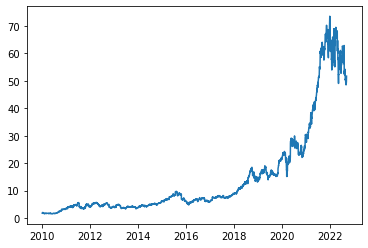

In [7]:
plt.plot(stock_data)

In [8]:
Ra = stock_data.pct_change()
Ra.head()

Date
2010-01-04         NaN
2010-01-05    0.021667
2010-01-06    0.055465
2010-01-07    0.002061
2010-01-08    0.033933
Name: Adj Close, dtype: float64

In [9]:
Ra.dropna(inplace = True)

In [10]:
Ra.head()

Date
2010-01-05    0.021667
2010-01-06    0.055465
2010-01-07    0.002061
2010-01-08    0.033933
2010-01-11   -0.002983
Name: Adj Close, dtype: float64

In [11]:
Rg = np.log(stock_data/stock_data.shift())
Rg.head()

Date
2010-01-04         NaN
2010-01-05    0.021435
2010-01-06    0.053981
2010-01-07    0.002059
2010-01-08    0.033370
Name: Adj Close, dtype: float64

In [12]:
Rg.dropna(inplace=True)
Rg.head()

Date
2010-01-05    0.021435
2010-01-06    0.053981
2010-01-07    0.002059
2010-01-08    0.033370
2010-01-11   -0.002988
Name: Adj Close, dtype: float64

In [13]:
from scipy import stats

Text(0.5, 1.0, 'Ra QQ-Plot')

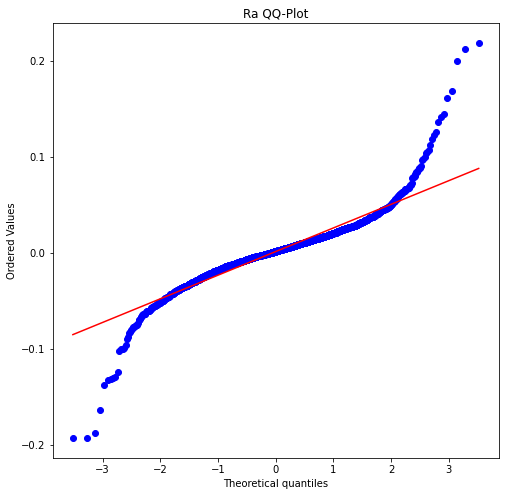

In [14]:
plt.figure(figsize=(8,8))
stats.probplot(Ra, dist="norm",plot=plt)
plt.title('Ra QQ-Plot')

Text(0.5, 1.0, 'Rg QQ-Plot')

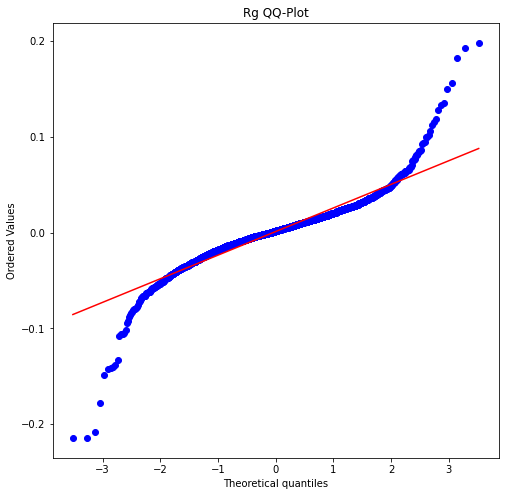

In [15]:
plt.figure(figsize=(8,8))
stats.probplot(Rg, dist="norm", plot=plt)
plt.title('Rg QQ-Plot')

Text(0.5, 1.0, 'Rg QQ-plot')

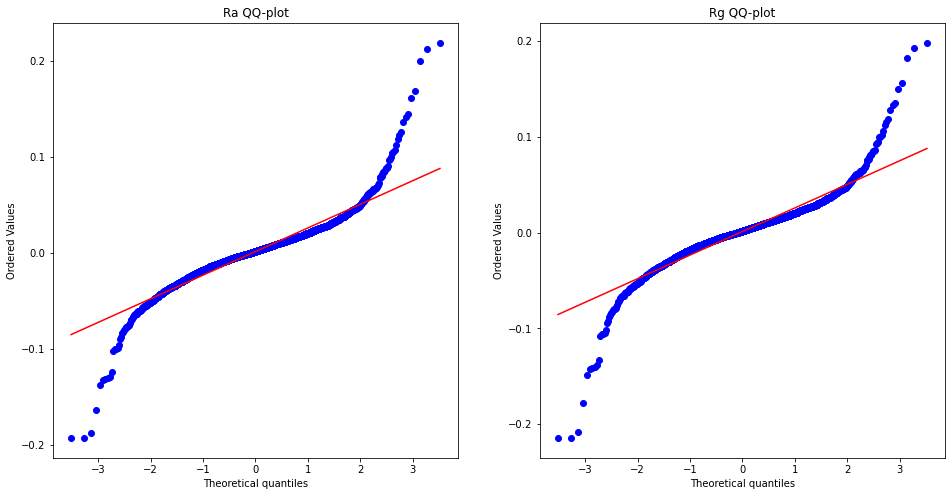

In [16]:
# Put together
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121)
stats.probplot(Ra, dist="norm", plot=ax1)
plt.title('Ra QQ-plot')
ax2 = fig.add_subplot(122)
stats.probplot(Rg, dist="norm", plot=ax2)
plt.title('Rg QQ-plot')

### 2.Calculate VaR

In [17]:
# Use the arithmetic rate of return
Ra.head()

Date
2010-01-05    0.021667
2010-01-06    0.055465
2010-01-07    0.002061
2010-01-08    0.033933
2010-01-11   -0.002983
Name: Adj Close, dtype: float64

#### 2.1 Historical Methods 

In [18]:
# Calculate 99% Daily VaR
VaRa_1_hs = np.percentile(Ra, 1)
VaRa_1_hs

-0.06481793445005621

In [19]:
# Calculate 95% Daily VaR
VaRa_5_hs = np.percentile(Ra, 5)
VaRa_5_hs

-0.03688374130416384

In [20]:
# Calculate 10 days 99% Daily VaR
VaRa_10_hs = VaRa_1_hs * np.sqrt(10)
VaRa_10_hs

-0.20497230608967115

Text(0, 0.5, 'count')

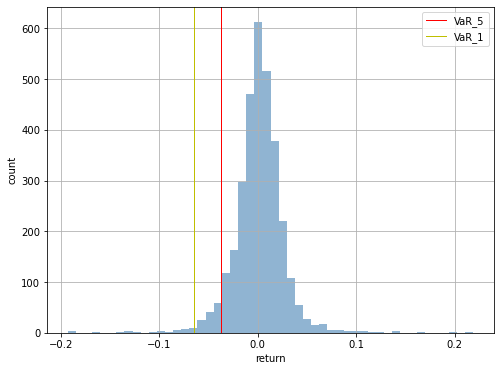

In [21]:
plt.figure(figsize= (8,6))
Ra.hist(bins=50, alpha=0.6, color='steelblue')
plt.axvline(VaRa_5_hs, color='r', linewidth=1,label = 'VaR_5')
plt.axvline(VaRa_1_hs, color='y', linewidth=1,label = 'VaR_1')
plt.legend()
plt.xlabel('return')
plt.ylabel('count')

#### 2.2 VaR Age-weighted Historical Simulation

In [22]:
Ra_df = pd.DataFrame(Ra.values, columns=['Ra'], index=Ra.index)
Ra_df.head()

,Ra
Date,
2010-01-05,0.021667
2010-01-06,0.055465
2010-01-07,0.002061
2010-01-08,0.033933
2010-01-11,-0.002983


In [23]:
Ra_df['order'] = np.arange(len(Ra_df),0,-1)
Ra_df.head()

,Ra,order
Date,,
2010-01-05,0.021667,3192
2010-01-06,0.055465,3191
2010-01-07,0.002061,3190
2010-01-08,0.033933,3189
2010-01-11,-0.002983,3188


In [24]:
Ra_df.tail()

,Ra,order
Date,,
2022-09-01,-0.002875,5
2022-09-02,0.001030,4
2022-09-06,0.021605,3
2022-09-07,0.016113,2
2022-09-08,0.024975,1


In [25]:
def calculate_weight(i, N, d):
    w = d**(i-1)*(1-d)/(1-d**N)
    return w

In [26]:
# Calculate weighted 
Ra_df['weight'] = Ra_df['order'].apply(calculate_weight, N=len(Ra_df), d=0.95)
Ra_df.head()

,Ra,order,weight
Date,,,
2010-01-05,0.021667,3192,4.120923e-73
2010-01-06,0.055465,3191,4.337813e-73
2010-01-07,0.002061,3190,4.566119e-73
2010-01-08,0.033933,3189,4.806442e-73
2010-01-11,-0.002983,3188,5.059412e-73


In [27]:
Ra_df.tail()

,Ra,order,weight
Date,,,
2022-09-01,-0.002875,5,0.040725
2022-09-02,0.001030,4,0.042869
2022-09-06,0.021605,3,0.045125
2022-09-07,0.016113,2,0.047500
2022-09-08,0.024975,1,0.050000


In [28]:
from statsmodels.stats.weightstats import DescrStatsW

In [29]:
wdf = DescrStatsW(Ra_df['Ra'], weights=Ra_df['weight']) 

wdf.quantile([0.05,0.01])                              

p
0.05   -0.028723
0.01   -0.163327
dtype: float64

In [30]:
VaRa_1_hs

-0.06481793445005621

In [31]:
VaRa_1_whs = wdf.quantile(0.01)
VaRa_1_whs

p
0.01   -0.163327
dtype: float64

In [32]:
VaRa_5_hs

-0.03688374130416384

In [33]:
VaRa_5_whs = wdf.quantile(0.05)
VaRa_5_whs

p
0.05   -0.028723
dtype: float64

#### 2.3 Resample HS

In [34]:
data_pool = Ra.dropna()
data_pool[:10]

Date
2010-01-05    0.021667
2010-01-06    0.055465
2010-01-07    0.002061
2010-01-08    0.033933
2010-01-11   -0.002983
2010-01-12   -0.012968
2010-01-13   -0.017686
2010-01-14    0.023663
2010-01-15   -0.013568
2010-01-19    0.008660
Name: Adj Close, dtype: float64

In [35]:
len(data_pool)

3192

In [36]:
sample = np.random.choice(data_pool, size=50, replace=True)
sample

array([ 0.00176655,  0.01145502,  0.06120566, -0.05099712, -0.00598288,
        0.01284793, -0.00650764,  0.03064727,  0.00932699,  0.01066983,
       -0.01663513, -0.0101843 , -0.01359217, -0.00811599,  0.00210191,
       -0.00065769, -0.02620215, -0.00307834,  0.00462247, -0.00290968,
        0.00607528,  0.0085107 ,  0.0140935 , -0.00071034,  0.00353587,
        0.01913212,  0.00632792, -0.0357759 ,  0.01110262,  0.01674942,
       -0.00185073,  0.02298019,  0.01533255,  0.00878869, -0.00786389,
        0.00471619,  0.01361787,  0.00195956,  0.00601506,  0.01790019,
        0.00437257, -0.00614382, -0.0029926 , -0.01032003,  0.02133846,
       -0.03870491, -0.02119282, -0.00964629,  0.01352416,  0.03677857])

In [37]:
VaR_5 = np.percentile(sample, 5)
VaR_1 = np.percentile(sample, 1)
f'Stock: 5%_VaR {VaR_5*100 : .2f}%, 1%_VaR: {VaR_1*100 : .2f}%'

'Stock: 5%_VaR -3.15%, 1%_VaR: -4.50%'

In [38]:
def sample_VaR(data, size):
    sample = np.random.choice(data, size, replace=True)
    VaR_5 = np.percentile(sample, 5)
    VaR_1 = np.percentile(sample, 1)
    return (VaR_5, VaR_1)

sample_VaR(data_pool, size=300)

(-0.039543702823825765, -0.06025991249555935)

In [39]:
samples = [sample_VaR(data_pool, 300) for i in range(1000)]
samples[:10]

[(-0.04496455694257261, -0.07314157967572416),
 (-0.03622154760744083, -0.05251910177582564),
 (-0.03700604220433932, -0.0579617447746516),
 (-0.03467004046231319, -0.07960103335875136),
 (-0.03816162745871089, -0.06420506499735835),
 (-0.03852620174168272, -0.07312182672421619),
 (-0.03587855094110983, -0.04672319070688929),
 (-0.03603164074971658, -0.07314157967572416),
 (-0.03662682705219844, -0.055949115231797526),
 (-0.03097568111544719, -0.06675545802185447)]

In [40]:
VaRs = pd.DataFrame(samples, columns=['VaR_5', 'VaR_1'])
VaRs.head()

,VaR_5,VaR_1
0,-0.044965,-0.073142
1,-0.036222,-0.052519
2,-0.037006,-0.057962
3,-0.034670,-0.079601
4,-0.038162,-0.064205


In [41]:
VaR_mean = VaRs.mean()
VaR_mean

VaR_5   -0.036544
VaR_1   -0.064451
dtype: float64

Text(0, 0.5, 'count')

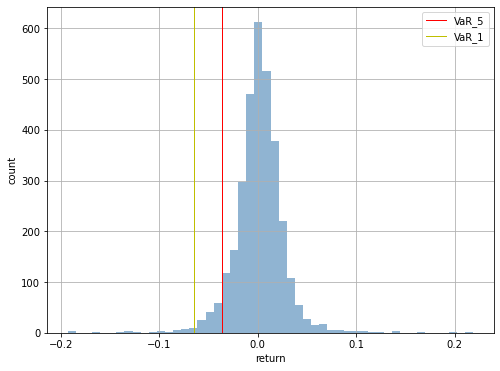

In [42]:
plt.figure(figsize= (8,6))
Ra.hist(bins=50, alpha=0.6, color='steelblue')
plt.axvline(VaR_mean.VaR_5, color='r', linewidth=1, label = 'VaR_5')
plt.axvline(VaR_mean.VaR_1, color='y', linewidth=1, label = 'VaR_1')
plt.xlabel('return')
plt.legend()
plt.ylabel('count')

#### 2.4 Parametric Method

In [43]:
mu_1 = Ra.mean()
sigma_1 = Ra.std()
print(f'Mean = {mu_1}') 
print( f'Standard Deviation = {sigma_1}')

Mean = 0.0013918543809276617
Standard Deviation = 0.026046394638290313


In [44]:
VaR_1_par = mu_1 - 2.33 * sigma_1
VaR_1_par

-0.05929624512628877

In [45]:
mu_10 = mu_1 * 10
sigma_10 = sigma_1 * np.sqrt(10)
VaR_10_par = mu_10 - 2.33 * sigma_10
VaR_10_par

-0.17799407750046956

#### 2.5 Monte Carlo Method

In [46]:
stock_data

Date
2010-01-04     1.800000
2010-01-05     1.839000
2010-01-06     1.941000
2010-01-07     1.945000
2010-01-08     2.011000
                ...    
2022-09-01    48.549999
2022-09-02    48.599998
2022-09-06    49.650002
2022-09-07    50.450001
2022-09-08    51.709999
Name: Adj Close, Length: 3193, dtype: float64

In [47]:
s_0 = stock_data[-1]

In [48]:
def GBM(s_0, mu, sigma, T, n):
    delta_t = T/n
    stimulated_price = [s_0]
    for i in range(n):
        start_price = stimulated_price[i]
        epsilon = np.random.normal()
        end_price = start_price + start_price * (mu*delta_t + sigma*epsilon*np.sqrt(delta_t))
        end_price = max(0, end_price)
        stimulated_price.append(end_price)
    return stimulated_price 

In [49]:
sim1 = GBM(s_0, mu_1, sigma_1,10,100)

In [50]:
sim1[-1]

49.32355716291059

In [51]:
len(sim1)

101

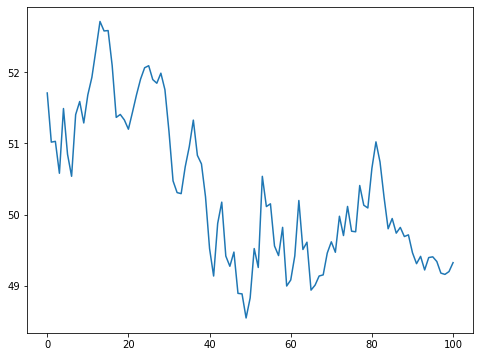

In [52]:
sim1 = pd.Series(sim1)
plt.figure(figsize=(8,6))
plt.plot(sim1)

In [53]:
# 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import matplotlib
import seaborn as sns

sns.set_style('whitegrid')

NCURVES = 300
# np.random.seed(0)

curves = [GBM(s_0, mu_1, sigma_1,1,100) for i in range(NCURVES)]

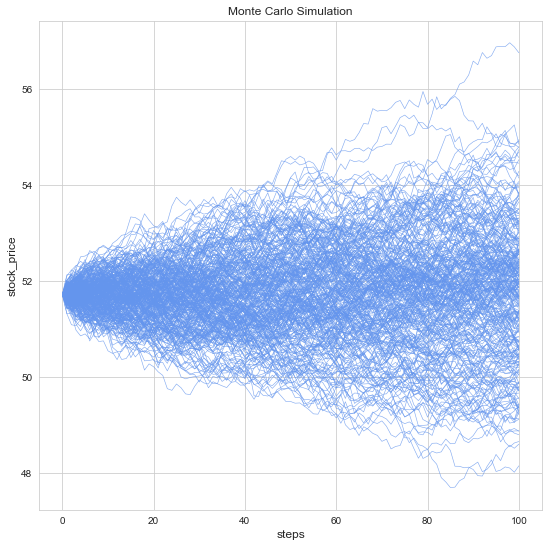

In [54]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
lines = []
for idx in range(len(curves)):
    line = curves[idx]
    retLine, = ax.plot(line,
                       color='cornflowerblue',
                       alpha=0.8,
                       linewidth=0.6)

plt.ylabel('stock_price', fontsize='large')
plt.xlabel('steps', fontsize='large')
plt.title('Monte Carlo Simulation', fontsize='large')
plt.show()

In [55]:
simulated_prices_1 = []
for i in range(10000):
    simulated_price = GBM(s_0, mu_1, sigma_1, 1,100)
    final_price = simulated_price[-1]
    simulated_prices_1.append(final_price)

In [56]:
simulated_prices_1[:10]

[52.475098416890916,
 52.024279324778526,
 49.82941552789178,
 54.4069534444586,
 53.07031268732378,
 51.53901459906649,
 51.00013836388623,
 49.80356816544424,
 51.18999347158906,
 51.62851790861981]

In [57]:
simulated_return_1 = simulated_prices_1/s_0-1           
simulated_return_1

array([ 0.01479596,  0.00607775, -0.03636789, ...,  0.01952144,
       -0.01664508, -0.02028876])

In [58]:
VaR_1 = np.percentile(simulated_return_1, 1)
VaR_1

-0.058253562305070984

In [59]:
VaR_10 =  VaR_1 * np.sqrt(10)
VaR_10 

-0.1842139387025528